In [1]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from scikeras.wrappers import KerasRegressor
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
def naive_roc_auc_score(y_true, y_pred):
  
  y_true = y_true.to_numpy()
  
  num_same_sign = 0
  num_pairs = 0
  
  for a in range(len(y_true)):
    for b in range(len(y_true)):
      if y_true[a] > y_true[b]:
        num_pairs += 1
        if y_pred[a] > y_pred[b]:
          num_same_sign += 1
        elif y_pred[a] == y_pred[b]:
          num_same_sign += .5
        
  return num_same_sign / num_pairs

# score = make_scorer(naive_roc_auc_score, greater_is_better=True)

In [6]:
def create_new_model():
 # create model
 model = Sequential()
 model.add(Dense(29, input_shape=(29,), activation='relu'))
 model.add(BatchNormalization())
 model.add(Dense(30, activation='relu'))
 model.add(BatchNormalization())
 model.add(Dropout(rate=0.2))
 model.add(BatchNormalization())
 model.add(Dense(10, activation='relu'))
 model.add(BatchNormalization())
 model.add(Dense(1))
 # Compile model
 opt = optimizers.Adam(learning_rate=0.003)
 model.compile(loss='MeanSquaredError', optimizer=opt, metrics=['accuracy'])
 return model

In [4]:
data = pd.read_csv('Dopant_Data.csv')

# get data
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['LUMO']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Absolute Partial Charge', 'Max Partial Charge', 
         'Min Abs Partial Charge', 'Min Partial Charge', 'Radical Electrons', 'Valence Electrons', 'NHOH Count', 'NO Count',
         'H Acceptors', 'H Donors', 'Ring Count', 'Aliphatic Rings', 'Aromatic Rings', 'Saturated Rings', 'Aromatic Carbocycles',
         'Aromatic Heterocycles', 'Heteroatoms', 'Rotatable Bonds', 'Saturated Carbocycles', 'Saturated Heterocycles', 'H Count',
         'C Count', 'N Count', 'F Count', 'Halogen Count', 'Double Bonds', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10)

scaler = StandardScaler().fit(X_train[list_numerical])
X_train[list_numerical] = scaler.transform(X_train[list_numerical])
X_test[list_numerical] = scaler.transform(X_test[list_numerical])

In [7]:
seed = 7
tf.random.set_seed(seed)
# load dataset
# create model
model = KerasRegressor(model=create_new_model, verbose=0)
# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv)
grid_cv = grid.fit(X_train, y_train)
# summarize results
print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", naive_roc_auc_score(y_train, grid_cv.predict(X_train)))
print("Test AUC ROC Score for GS: ",naive_roc_auc_score(y_test, grid_cv.predict(X_test)))
print('Train Mean Absolute Error:', abs(grid_cv.predict(X_train) - y_train), 'degrees.')
print('Test Mean Absolute Error:', abs(grid_cv.predict(X_test) - y_test), 'degrees.')

# prediction = model.predict(X_test)
# mse = mean_squared_error(y_test, prediction)
# #calculate R-squared of regression model
# r_squared = model.score(X_test, y_test)

#view R-squared value
print("Train R2: ", r2_score(y_train, grid_cv.predict(X_train)))
print("Test R2: ", r2_score(y_test, grid_cv.predict(X_test)))
# rmse = mse**.5
print("Train MSE: ", mean_squared_error(y_train, grid_cv.predict(X_train)))
print("Test MSE: ", mean_squared_error(y_test, grid_cv.predict(X_test)))

Param for GS {'batch_size': 20, 'epochs': 100}
CV score for GS 0.038430051374284874
Train AUC ROC Score for GS:  0.9576923076923077
Test AUC ROC Score for GS:  0.9
Train Mean Absolute Error: 23    0.679343
18    0.560379
3     0.107930
41    0.299780
7     0.133901
6     0.444001
2     0.499828
37    0.068089
39    0.218847
35    0.858617
44    0.838835
27    0.292149
12    0.472997
31    0.660054
21    0.385877
5     0.697345
13    0.515053
19    1.090830
17    0.104009
14    0.700252
4     0.026932
45    0.705908
1     0.712475
26    0.448944
32    0.326714
24    0.429682
22    0.293614
11    0.370280
16    0.728957
43    0.767485
46    0.802441
8     0.075628
38    0.758476
29    0.268193
25    0.520357
28    0.163958
0     0.044931
15    0.877029
36    0.623222
9     0.476911
Name: LUMO, dtype: float64 degrees.
Test Mean Absolute Error: 30    0.169382
10    0.748191
20    0.930256
33    0.844694
34    1.045060
Name: LUMO, dtype: float64 degrees.
Train R2:  0.9458992893819906
Test R

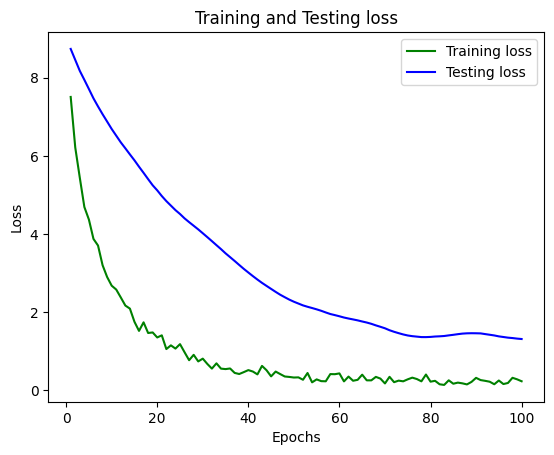

In [8]:
model = KerasRegressor(model=create_new_model, verbose=0)
model.fit(X_train, y_train, epochs=100, batch_size=80, validation_data=(X_test, y_test))
loss_train = model.history_['loss']
loss_val = model.history_['val_loss']
epochs = range(1,101)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Testing loss')
plt.title('Training and Testing loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()